In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as tp
import time
import tqdm
from calendar import monthrange
import calendar
from xgboost import XGBRegressor
from xgboost import plot_importance
#from tqdm import tqdm_notebook as tqdm

In [2]:
train = pd.read_csv('train.csv')
train = train.drop('Unnamed: 0', axis = 1)
train.info()
train.item_cnt_month = train.item_cnt_month.clip(0,20)
lags = [1,2,3,6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609116 entries, 0 to 1609115
Data columns (total 5 columns):
shop_id           1609116 non-null int64
item_id           1609116 non-null int64
date_block_num    1609116 non-null int64
item_cnt_month    1609116 non-null int64
item_cat          1609116 non-null int64
dtypes: int64(5)
memory usage: 61.4 MB


In [3]:
# prepare the test dataset to merge with the training dataset
test = pd.read_csv('test.csv')
itemcat = pd.read_csv('items.csv')
#itemcat.head()
test = test.drop('ID',axis=1)
test['date_block_num'] = 34
test['item_cnt_month'] = 0
test['item_cat'] = ''
itemcat.head()
ts = time.time()
for i in tqdm.tqdm(test.item_id.unique()):
    test.loc[test.item_id == i, 'item_cat'] = itemcat.loc[itemcat.item_id == i, 'item_category_id'].values[0]

print(time.time()-ts)
test.info()

100%|██████████| 5100/5100 [01:21<00:00, 62.24it/s]


81.9409761429
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 5 columns):
shop_id           214200 non-null int64
item_id           214200 non-null int64
date_block_num    214200 non-null int64
item_cnt_month    214200 non-null int64
item_cat          214200 non-null int64
dtypes: int64(5)
memory usage: 8.2 MB


In [4]:
#test = test.drop('ID',axis=1)
#test.head()
matrix = pd.concat([train,test], keys = ['shop_id','item_id','date_block_num'], ignore_index = True, sort= False)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823316 entries, 0 to 1823315
Data columns (total 5 columns):
shop_id           int64
item_id           int64
date_block_num    int64
item_cnt_month    int64
item_cat          int64
dtypes: int64(5)
memory usage: 69.6 MB


In [5]:
train = matrix
train.date_block_num.unique()

array([ 1,  0, 17,  2,  5, 15, 16,  3, 33, 12, 14, 18, 20, 21, 23, 26, 31,
       10, 11, 25, 27, 28, 30, 32, 24,  6,  9,  7,  8, 13,  4, 19, 22, 29,
       34])

In [6]:
del matrix

In [7]:
# Function for introducing lag features in the dataset. "COL" is the intended feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]] #made a temporary dataframe
    for i in tqdm.tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

ts = time.time()
train = lag_feature(train, lags, 'item_cnt_month')
time.time() - ts

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


3.3172049522399902

In [8]:
train.fillna(0, inplace = True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823316 entries, 0 to 1823315
Data columns (total 9 columns):
shop_id                 int64
item_id                 int64
date_block_num          int64
item_cnt_month          int64
item_cat                int64
item_cnt_month_lag_1    float64
item_cnt_month_lag_2    float64
item_cnt_month_lag_3    float64
item_cnt_month_lag_6    float64
dtypes: float64(4), int64(5)
memory usage: 139.1 MB


In [10]:
#item price information is missing. lets add it
sales_train = pd.read_csv('sales_train.csv')
print('Size of dataset before outliers: {}'.format(sales_train.shape))
sales_train = sales_train[sales_train['item_price']<50000]
sales_train = sales_train[sales_train['item_cnt_day']<600]
sales_train = sales_train[sales_train['item_price']>0]
print('Size of dataset after removing outliers: {}'.format(sales_train.shape))

Size of dataset before outliers: (2935849, 6)
Size of dataset after removing outliers: (2935840, 6)


In [11]:
exp = sales_train.groupby(['shop_id','item_id','date_block_num'])['item_price'].max()

In [12]:
exp = pd.DataFrame(exp).reset_index()
exp.head(5)

,shop_id,item_id,date_block_num,item_price
0,0,30,1,265.0
1,0,31,1,434.0
2,0,32,0,221.0
3,0,32,1,221.0
4,0,33,0,347.0


In [13]:
matrix = pd.merge(train,exp,on=['shop_id','item_id','date_block_num'],how = 'left')
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823316 entries, 0 to 1823315
Data columns (total 10 columns):
shop_id                 int64
item_id                 int64
date_block_num          int64
item_cnt_month          int64
item_cat                int64
item_cnt_month_lag_1    float64
item_cnt_month_lag_2    float64
item_cnt_month_lag_3    float64
item_cnt_month_lag_6    float64
item_price              float64
dtypes: float64(5), int64(5)
memory usage: 153.0 MB


In [14]:
matrix.fillna(0,inplace=True)
train = matrix

In [15]:
del matrix
del exp
del test
del itemcat

In [16]:
# Price analysis. In this section we will dome some experiment on price analysis will see if there are ups and
# downs in price

In [17]:
train.columns

Index([u'shop_id', u'item_id', u'date_block_num', u'item_cnt_month',
       u'item_cat', u'item_cnt_month_lag_1', u'item_cnt_month_lag_2',
       u'item_cnt_month_lag_3', u'item_cnt_month_lag_6', u'item_price'],
      dtype='object')

In [18]:
# we don't have any information about 34th month price. We will have to use prior information. The information about
# last time sell

In [19]:
exp = sales_train.groupby(['shop_id','item_id','date_block_num'])['item_price'].max() #all shop-item price
exp = pd.DataFrame(exp).reset_index()
exp1 = sales_train.groupby(['shop_id','item_id'])['date_block_num'].max() # extracting the immediate last sales history
exp1 = pd.DataFrame(exp1).reset_index()
matrix = pd.merge(exp1,exp, on=['shop_id','item_id','date_block_num'], how = 'inner')
matrix['date_block_num'] = 34
temp = pd.merge(train,matrix,on=['shop_id','item_id','date_block_num'], how = 'left')
temp.info()
#matrix = train[train.date_block_num==34]
#matrix = pd.merge(matrix,exp,on=['shop_id','item_id'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823316 entries, 0 to 1823315
Data columns (total 11 columns):
shop_id                 int64
item_id                 int64
date_block_num          int64
item_cnt_month          int64
item_cat                int64
item_cnt_month_lag_1    float64
item_cnt_month_lag_2    float64
item_cnt_month_lag_3    float64
item_cnt_month_lag_6    float64
item_price_x            float64
item_price_y            float64
dtypes: float64(6), int64(5)
memory usage: 166.9 MB


In [20]:
temp.fillna(0,inplace=True)
temp['item_price'] = ''
temp['item_price'] = temp['item_price_x'] + temp['item_price_y']
temp = temp.drop(columns = ['item_price_x','item_price_y'], axis=1)

In [21]:
train = temp[temp.item_price>0] # shop+item duo for which data available in training set
remainder = temp[temp.item_price==0] # shop+item duo for which no data available in training set, different approach required

In [22]:
del exp
del temp
del exp1
del matrix

In [23]:
# Now we shall do some investigation on item price over both shop and time

In [24]:
exp = sales_train.groupby(['shop_id','item_id'])['item_price'].max()
exp = pd.DataFrame(exp).reset_index()
exp.rename(columns={'item_price':'max'}, inplace = True)
exp.head()

,shop_id,item_id,max
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [25]:
exp1 = sales_train.groupby(['shop_id','item_id'])['item_price'].min()
exp1 = pd.DataFrame(exp1).reset_index()
exp1.rename(columns={'item_price':'min'}, inplace = True)
exp1.head()

,shop_id,item_id,min
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [26]:
matrix = pd.merge(exp,exp1, on=['shop_id','item_id'],how = 'left')

In [27]:
matrix.head()

,shop_id,item_id,max,min
0,0,30,265.0,265.0
1,0,31,434.0,434.0
2,0,32,221.0,221.0
3,0,33,347.0,347.0
4,0,35,247.0,247.0


In [28]:
matrix['change'] = np.abs(matrix['max'] -matrix['min'])

In [29]:
matrix

,shop_id,item_id,max,min,change
0,0,30,265.00,265.00,0.00
1,0,31,434.00,434.00,0.00
2,0,32,221.00,221.00,0.00
3,0,33,347.00,347.00,0.00
4,0,35,247.00,247.00,0.00
5,0,36,357.00,357.00,0.00
6,0,40,127.00,127.00,0.00
7,0,42,127.00,127.00,0.00
8,0,43,221.00,221.00,0.00
9,0,49,127.00,127.00,0.00


In [30]:
# This means there is a change of item price over TIME. Now we need to see if there is variation of item price
# over the SHOPS. 

In [31]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [32]:
shop_matrix = sales_train.pivot_table(index=['date','item_id'], columns = 'shop_id', values = 'item_price',aggfunc= np.mean, fill_value=0)

In [33]:
shop_matrix = shop_matrix.droplevel('date',axis=0)

In [34]:
shop_matrix_2d = shop_matrix.values

In [35]:
for i in range (0,shop_matrix_2d.shape[0]):
    maxs = np.max(shop_matrix_2d[i])
    shop_matrix_2d[i] = shop_matrix_2d[i]/maxs

In [36]:
shop_matrix_2d.shape

(1541608, 60)

In [37]:
shop_index = np.zeros((60,1)) # shop_index determines the usual practice of selling a product in a shopt
for i in range(0,shop_matrix_2d.shape[1]):
    temp = shop_matrix_2d[:][i]
    shop_index[i] = np.mean(temp[temp>0])
    #shop_index[i] = np.mean(np.unique(shop_matrix_2d[:][i]))

In [38]:
train['shop_index'] = ''

In [39]:
for i in range(0,60):
    train.loc[train.shop_id==i,'shop_index'] = shop_index[i]

In [40]:
np.min(train.shop_index)

0.7208835341365462

In [41]:
def nday_month(x):
    if x<12:
        year = 2013
    if x>=12 and x<22:
        year = 2014
    if x>=22:
        year = 2015
    month = np.mod(x,12) + 1
    temp = monthrange(year,month)[1]
    return temp

In [42]:
nday_month(32)

30

In [43]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index
0,0,30,1,20,40,0.0,0.0,0.0,0.0,265.0,0.999733
1,0,31,1,11,37,0.0,0.0,0.0,0.0,434.0,0.999733
2,0,32,0,6,40,0.0,0.0,0.0,0.0,221.0,0.999733
3,0,32,1,10,40,6.0,0.0,0.0,0.0,221.0,0.999733
4,0,33,0,3,37,0.0,0.0,0.0,0.0,347.0,0.999733


In [44]:
train['day_in_month'] = ''

In [45]:
train['day_in_month'] = train.date_block_num.apply(lambda x: nday_month(x))

In [46]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month
0,0,30,1,20,40,0.0,0.0,0.0,0.0,265.0,0.999733,28
1,0,31,1,11,37,0.0,0.0,0.0,0.0,434.0,0.999733,28
2,0,32,0,6,40,0.0,0.0,0.0,0.0,221.0,0.999733,31
3,0,32,1,10,40,6.0,0.0,0.0,0.0,221.0,0.999733,28
4,0,33,0,3,37,0.0,0.0,0.0,0.0,347.0,0.999733,31


In [47]:
def wday_month(x):
    if x<12:
        year = 2013
    if x>=12 and x<22:
        year = 2014
    if x>=22:
        year = 2015
    month = np.mod(x,12) + 1
    temp = np.array(calendar.monthcalendar(year,month))[:,calendar.SATURDAY]
    return (temp>0).sum()

In [48]:
train['wday_in_month'] = ''

In [49]:
train['wday_in_month'] = train.date_block_num.apply(lambda x: wday_month(x))

In [50]:
train['month_index'] = ''

In [51]:
train['month_index'] = train.date_block_num.apply(lambda x: np.mod(x,12)+1)

In [52]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month,wday_in_month,month_index
0,0,30,1,20,40,0.0,0.0,0.0,0.0,265.0,0.999733,28,4,2
1,0,31,1,11,37,0.0,0.0,0.0,0.0,434.0,0.999733,28,4,2
2,0,32,0,6,40,0.0,0.0,0.0,0.0,221.0,0.999733,31,4,1
3,0,32,1,10,40,6.0,0.0,0.0,0.0,221.0,0.999733,28,4,2
4,0,33,0,3,37,0.0,0.0,0.0,0.0,347.0,0.999733,31,4,1


In [53]:
# add previous price point as lag feature
del temp
temp = train.copy()
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]] #made a temporary dataframe
    for i in tqdm.tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
temp = lag_feature(train,lags,'item_price')

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


In [54]:
temp.loc[temp.item_price_lag_1.isnull(),'item_price_lag_1'] = temp.item_price

In [55]:
temp.loc[temp.item_price_lag_2.isnull(),'item_price_lag_2'] = temp.item_price_lag_1
temp.loc[temp.item_price_lag_3.isnull(),'item_price_lag_3'] = temp.item_price_lag_2
temp.loc[temp.item_price_lag_6.isnull(),'item_price_lag_6'] = temp.item_price_lag_3
#temp.loc[temp.item_price_lag_12.isnull(),'item_price_lag_12'] = temp.item_price_lag_6

In [56]:
temp

,shop_id,item_id,date_block_num,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month,wday_in_month,month_index,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_6
0,0,30,1,20,40,0.0,0.0,0.0,0.0,265.00,0.999733,28,4,2,265.00,265.00,265.00,265.00
1,0,31,1,11,37,0.0,0.0,0.0,0.0,434.00,0.999733,28,4,2,434.00,434.00,434.00,434.00
2,0,32,0,6,40,0.0,0.0,0.0,0.0,221.00,0.999733,31,4,1,221.00,221.00,221.00,221.00
3,0,32,1,10,40,6.0,0.0,0.0,0.0,221.00,0.999733,28,4,2,221.00,221.00,221.00,221.00
4,0,33,0,3,37,0.0,0.0,0.0,0.0,347.00,0.999733,31,4,1,347.00,347.00,347.00,347.00
5,0,33,1,3,37,3.0,0.0,0.0,0.0,347.00,0.999733,28,4,2,347.00,347.00,347.00,347.00
6,0,35,0,1,40,0.0,0.0,0.0,0.0,247.00,0.999733,31,4,1,247.00,247.00,247.00,247.00
7,0,35,1,14,40,1.0,0.0,0.0,0.0,247.00,0.999733,28,4,2,247.00,247.00,247.00,247.00
8,0,36,1,1,37,0.0,0.0,0.0,0.0,357.00,0.999733,28,4,2,357.00,357.00,357.00,357.00
9,0,40,1,1,57,0.0,0.0,0.0,0.0,127.00,0.999733,28,4,2,127.00,127.00,127.00,127.00


In [57]:
# We have included lag price feature under some assumption: If no previous price history can be obtained, use the present price point as the previous one
train = temp
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720520 entries, 0 to 1720519
Data columns (total 18 columns):
shop_id                 int64
item_id                 int64
date_block_num          int64
item_cnt_month          int64
item_cat                int64
item_cnt_month_lag_1    float64
item_cnt_month_lag_2    float64
item_cnt_month_lag_3    float64
item_cnt_month_lag_6    float64
item_price              float64
shop_index              object
day_in_month            int64
wday_in_month           int64
month_index             int64
item_price_lag_1        float64
item_price_lag_2        float64
item_price_lag_3        float64
item_price_lag_6        float64
dtypes: float64(9), int64(8), object(1)
memory usage: 329.4+ MB


In [58]:
def downcast(df):
    #finding floating point columns
    float_cols = [c for c in df if df[c].dtype == 'float64']
    #finding integer columns
    int_cols = [c for c in df if df[c].dtype in ['int32','int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720520 entries, 0 to 1720519
Data columns (total 18 columns):
shop_id                 int16
item_id                 int16
date_block_num          int16
item_cnt_month          int16
item_cat                int16
item_cnt_month_lag_1    float32
item_cnt_month_lag_2    float32
item_cnt_month_lag_3    float32
item_cnt_month_lag_6    float32
item_price              float32
shop_index              object
day_in_month            int16
wday_in_month           int16
month_index             int16
item_price_lag_1        float32
item_price_lag_2        float32
item_price_lag_3        float32
item_price_lag_6        float32
dtypes: float32(9), int16(8), object(1)
memory usage: 191.6+ MB


In [59]:
exp = train.groupby(['date_block_num','item_id'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_item_sale'})
temp = pd.merge(train,exp,on=['item_id','date_block_num'],how = 'left')
temp.avg_item_sale = temp.avg_item_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_item_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_item_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720520 entries, 0 to 1720519
Data columns (total 22 columns):
shop_id                 int16
item_id                 int16
date_block_num          int16
item_cnt_month          int16
item_cat                int16
item_cnt_month_lag_1    float32
item_cnt_month_lag_2    float32
item_cnt_month_lag_3    float32
item_cnt_month_lag_6    float32
item_price              float32
shop_index              float64
day_in_month            int16
wday_in_month           int16
month_index             int16
item_price_lag_1        float32
item_price_lag_2        float32
item_price_lag_3        float32
item_price_lag_6        float32
avg_item_sale_lag_1     float32
avg_item_sale_lag_2     float32
avg_item_sale_lag_3     float32
avg_item_sale_lag_6     float32
dtypes: float32(13), float64(1), int16(8)
memory usage: 137.8 MB


In [61]:
exp = train.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_shop_sale'})
temp = pd.merge(train,exp,on=['shop_id','date_block_num'],how = 'left')
temp.avg_shop_sale = temp.avg_shop_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_shop_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_shop_sale'],axis=1)

100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


In [62]:
train = temp
traincopy = train.copy()

In [63]:
exp = train.groupby(['date_block_num','item_cat'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_cat_sale'})
temp = pd.merge(train,exp,on=['item_cat','date_block_num'],how = 'left')
temp.avg_cat_sale = temp.avg_cat_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_cat_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_cat_sale'],axis=1)
train = temp
traincopy = train.copy

100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


In [64]:
exp = train.groupby(['date_block_num','item_id'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_item_sale'})
temp = pd.merge(train,exp,on=['item_id','date_block_num'],how = 'left')
temp.tot_item_sale = temp.tot_item_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_item_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_item_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [65]:
exp = train.groupby(['date_block_num','shop_id'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_shop_sale'})
temp = pd.merge(train,exp,on=['shop_id','date_block_num'],how = 'left')
temp.tot_shop_sale = temp.tot_shop_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_shop_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_shop_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


In [66]:
exp = train.groupby(['date_block_num','item_cat'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_cat_sale'})
temp = pd.merge(train,exp,on=['item_cat','date_block_num'],how = 'left')
temp.tot_cat_sale = temp.tot_cat_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_cat_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_cat_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


In [66]:
# Price Trend Feature
matrix = train.copy()
def strend(row):
    for i in lags:
        if row['pr_trend_lag_'+str(i)]:
            return row['pr_trend_lag_'+str(i)]
    return 0

exp = matrix.groupby('item_id')['item_price'].mean()
exp = pd.DataFrame(exp)
exp = exp.reset_index()
exp = exp.rename(columns={'item_price':'avg_item_price'})
matrix = pd.merge(matrix,exp,on=['item_id'],how='left')
for i in lags:
    matrix['pr_trend_lag_'+str(i)] = ''
    matrix['pr_trend_lag_'+str(i)] = (matrix['item_price_lag_'+str(i)] - matrix['avg_item_price'])/matrix['avg_item_price']
matrix['slope_price'] = matrix.apply(strend, axis=1)
drop_item = ['avg_item_price']
for i in lags:
    drop_item += ['pr_trend_lag_'+str(i)]
matrix = matrix.drop(columns=drop_item,axis=1)
#train = matrix
#traincopy = train.copy()

In [68]:
train = matrix
traincopy = train.copy()
del matrix

In [71]:
############### MODEL PREPARATION ###################
train = traincopy
train.columns

Index([u'shop_id', u'item_id', u'date_block_num', u'item_cnt_month',
       u'item_cat', u'item_cnt_month_lag_1', u'item_cnt_month_lag_2',
       u'item_cnt_month_lag_3', u'item_cnt_month_lag_6', u'item_price',
       u'shop_index', u'day_in_month', u'wday_in_month', u'month_index',
       u'item_price_lag_1', u'item_price_lag_2', u'item_price_lag_3',
       u'item_price_lag_6', u'avg_item_sale_lag_1', u'avg_item_sale_lag_2',
       u'avg_item_sale_lag_3', u'avg_item_sale_lag_6', u'avg_shop_sale_lag_1',
       u'avg_shop_sale_lag_2', u'avg_shop_sale_lag_3', u'avg_shop_sale_lag_6',
       u'avg_cat_sale_lag_1', u'avg_cat_sale_lag_2', u'avg_cat_sale_lag_3',
       u'avg_cat_sale_lag_6', u'tot_item_sale_lag_1', u'tot_item_sale_lag_2',
       u'tot_item_sale_lag_3', u'tot_item_sale_lag_6', u'tot_shop_sale_lag_1',
       u'tot_shop_sale_lag_2', u'tot_shop_sale_lag_3', u'tot_shop_sale_lag_6',
       u'slope_price', u'monthly_sale_lag_1', u'monthly_sale_lag_2',
       u'monthly_sale_lag_3', u

In [70]:
#monthly sale
exp = sales_train.groupby('date_block_num')['item_cnt_day'].sum()
monthly_sale = pd.DataFrame(exp).reset_index()
temp = pd.merge(train,monthly_sale,on=['date_block_num'],how= 'left')
temp = temp.rename(columns = {'item_cnt_day':'monthly_sale'})
temp = lag_feature(temp,lags,'monthly_sale')
temp.fillna(0,inplace= True)
temp = temp.drop(columns=['monthly_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


In [74]:
train = traincopy
#train = train.drop(columns=['tot_cat_sale','tot_item_sale','tot_shop_sale'],axis=1)
#train['item_cnt_month'] = train.item_cnt_month.clip(0,20)
train.fillna(0,inplace=True)
train['shop_index'] = train['shop_index'].astype(np.float32)
train = train[train['date_block_num']>= np.max(lags)]
valid_month = 33
test_month = 34
xtrain = train[train.date_block_num<valid_month].drop(columns='item_cnt_month', axis =1)
ytrain = train[train.date_block_num<valid_month]['item_cnt_month']
xvalid = train[train.date_block_num==valid_month].drop(columns='item_cnt_month', axis =1)
yvalid = train[train.date_block_num==valid_month]['item_cnt_month']
xtest = train[train.date_block_num==test_month].drop(columns='item_cnt_month', axis =1)

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=12,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    xtrain, 
    ytrain, 
    eval_metric="rmse", 
    eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:2.81829	validation_1-rmse:2.78786
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.66106	validation_1-rmse:2.67309
[2]	validation_0-rmse:2.52284	validation_1-rmse:2.56506
[3]	validation_0-rmse:2.39896	validation_1-rmse:2.48682
[4]	validation_0-rmse:2.29045	validation_1-rmse:2.41668
[5]	validation_0-rmse:2.20079	validation_1-rmse:2.36583
[6]	validation_0-rmse:2.11927	validation_1-rmse:2.30671
[7]	validation_0-rmse:2.04854	validation_1-rmse:2.26188
[8]	validation_0-rmse:1.98539	validation_1-rmse:2.2249
[9]	validation_0-rmse:1.93487	validation_1-rmse:2.19864
[10]	validation_0-rmse:1.88704	validation_1-rmse:2.17377
[11]	validation_0-rmse:1.84532	validation_1-rmse:2.15994
[12]	validation_0-rmse:1.81282	validation_1-rmse:2.13984
[13]	validation_0-rmse:1.77926	validation_1-rmse:2.127
[14]	validation_0-rmse:1.75074	validation_1-rmse:2.11485

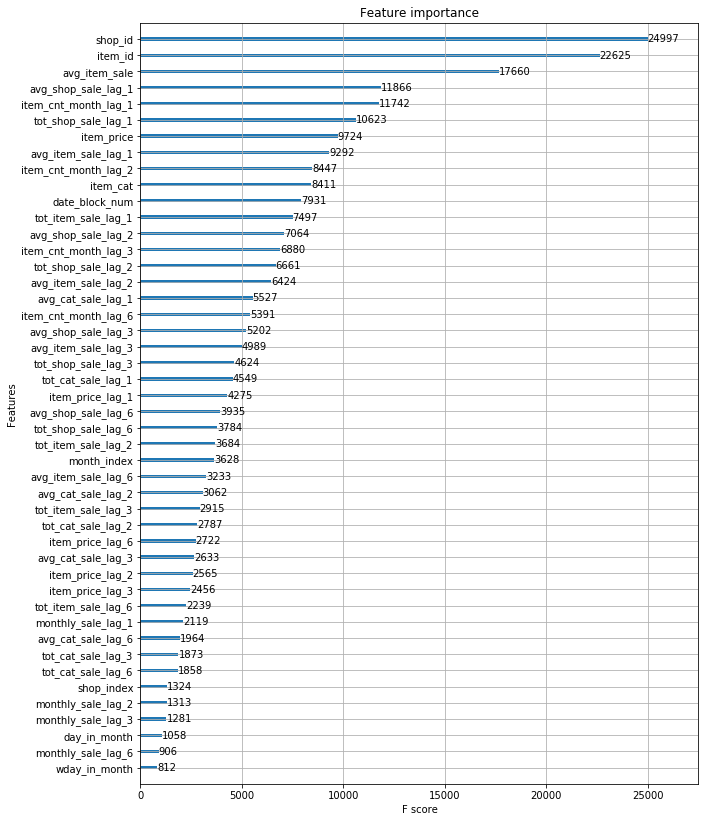

In [71]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))

In [72]:
ypred = model.predict(xtest)

In [73]:
ypred

array([ 0.09160468, -0.01702684, -0.00535411, ..., -0.05605859,
        0.02042603,  0.06449398], dtype=float32)

In [74]:
## Preparing submission file
test = pd.read_csv('test.csv')

In [75]:
temp = xtest[['shop_id','item_id']]
temp['item_cnt_month'] = ypred

/home/tanweer/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
submission = pd.concat((remainder[['shop_id','item_id','item_cnt_month']],temp))

In [77]:
exp = pd.merge(test,submission,on=['shop_id','item_id'], how= 'left')
exp = exp.drop(columns=['shop_id','item_id'], axis = 1)
exp.item_cnt_month = exp.item_cnt_month.clip(0,20)

In [78]:
exp.to_csv('submission_xgboost1.csv', index = False)